In [60]:
import wntr

import matplotlib.pyplot as plt
import wntr.graphics.network as wntr_graphics

import pandas as pd
import numpy as np

import copy

In [61]:
def civic_validator(wn):
    print("🔍 Running Sockford Civic Validator...\n")

    phantom_nodes = []
    undefined_links = []
    zero_coord_nodes = []

    # Check for nodes at (0,0)
    for name, node in wn.nodes():
        if hasattr(node, 'coordinates') and node.coordinates == (0, 0):
            zero_coord_nodes.append(name)

    # Check for links referencing undefined nodes
    for link_name, link in wn.links():
        if link.start_node_name not in wn.node_name_list or link.end_node_name not in wn.node_name_list:
            undefined_links.append(link_name)

    # Check for nodes not in junctions, tanks, or reservoirs
    all_nodes = set(wn.node_name_list)
    declared_nodes = set(wn.junction_name_list + wn.tank_name_list + wn.reservoir_name_list)
    phantom_nodes = list(all_nodes - declared_nodes)

    # Report
    if zero_coord_nodes:
        print(f"⚠️ Nodes at (0,0): {zero_coord_nodes}")
    if undefined_links:
        print(f"⚠️ Links referencing undefined nodes: {undefined_links}")
    if phantom_nodes:
        print(f"⚠️ Phantom nodes (undeclared): {phantom_nodes}")
    if not (zero_coord_nodes or undefined_links or phantom_nodes):
        print("✅ No phantom nodes or misregistrations detected.")

    print("\n🧾 Civic audit complete.")


In [62]:
# Load network

# works on my system
#wn = wntr.network.WaterNetworkModel('data/Net1_EPANET-EXAMPLE_1s.inp') 
wn = wntr.network.WaterNetworkModel('data/Net3_EPANET-EXAMPLE_No_Demand_Change.inp')

# does not work on my system
#wn = wntr.network.WaterNetworkModel('data/Net3_EPANET-EXAMPLE.inp') 
#wn = wntr.network.WaterNetworkModel('data/Micropolis_TEVA-SPOT_Adjusted_PumpCurve3&4.inp')
#wn = wntr.network.WaterNetworkModel('data/Net3_(BWSN-2)_Morph_Error_Free_1s-WQ.inp')

#civic_validator(wn)

# Run simulation
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
print("Simulation complete!")

Simulation complete!


In [63]:
# Get list of nodes and links
print("Nodes:", wn.node_name_list[:10])
print("Links:", wn.link_name_list[:10])

# Example: pressures at all nodes (in meters of head)
pressure = results.node['pressure']

# Look at the first few timesteps
pressure.head()


Nodes: ['10', '15', '20', '35', '40', '50', '60', '601', '61', '101']
Links: ['20', '40', '50', '60', '101', '103', '105', '107', '109', '111']


name,10,15,20,35,40,50,60,601,61,101,...,267,269,271,273,275,River,Lake,1,2,3
0,-0.174092,28.545839,8.839199,40.542843,3.992880,7.162800,63.663086,91.898102,91.898102,31.829906,...,38.219528,44.612568,42.552387,40.485798,39.669624,0.0,0.0,3.992880,7.162800,8.839199
3600,-0.062931,28.681910,8.993134,40.652149,4.158386,6.872975,63.669914,91.943657,91.943657,31.941069,...,38.327930,44.719654,42.660095,40.525455,39.696297,0.0,0.0,4.158386,6.872975,8.993134
7200,0.047081,28.814392,9.141540,40.758785,4.289490,6.724143,63.676575,91.988091,91.988091,32.051079,...,38.435318,44.825863,42.765919,40.588326,39.753468,0.0,0.0,4.289490,6.724143,9.141535
10800,0.155874,28.943449,9.284889,40.863327,4.402883,6.663337,63.683067,92.031479,92.031479,32.159874,...,38.541653,44.931103,42.870136,40.666588,39.829449,0.0,0.0,4.402883,6.663337,9.284884
14400,0.264193,29.069525,9.423593,40.967365,4.509267,6.655691,63.689415,92.073936,92.073936,32.268192,...,38.647770,45.036251,42.974075,40.753967,39.915688,0.0,0.0,4.509267,6.655691,9.423593


In [64]:
print(results.node['pressure'].index)


Index([    0,  3600,  7200, 10800, 14400, 18000, 21600, 25200, 28800, 32400,
       36000, 39600, 43200, 46800, 50400, 54000, 57600, 61200, 64800, 68400,
       72000, 75600, 79200, 82800, 86400],
      dtype='int32')


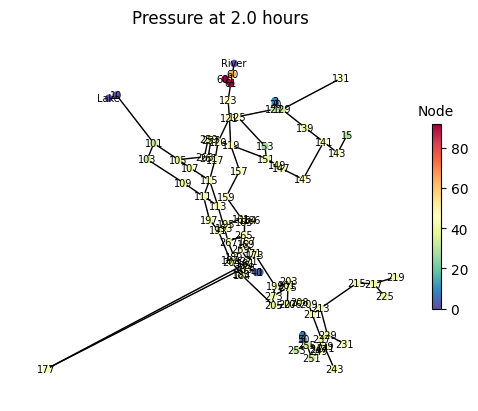

In [65]:


# Select one timestep (e.g. 2 hours = 7200 seconds)
t = 7200

# Plot the network colored by pressure
wntr_graphics.plot_network(
    wn, 
    node_labels=True,
    node_attribute=pressure.loc[t, :],
    node_size=30,
    title=f"Pressure at {t/3600:.1f} hours"
)
plt.show()


In [66]:
wn.pump_name_list

['10', '335']

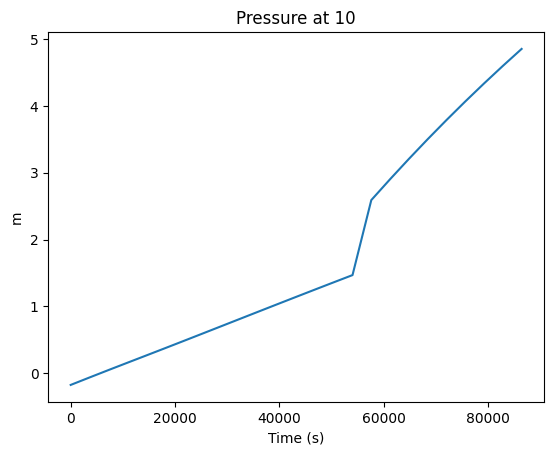

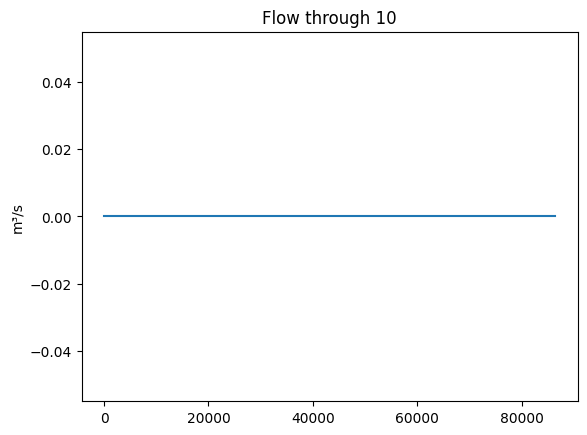

In [67]:
# Plot pressure at one node through time
node_name = wn.junction_name_list[0]
pressure[node_name].plot(title=f"Pressure at {node_name}", ylabel='m', xlabel='Time (s)')
plt.show()

# Energy usage or flow data
flow = results.link['flowrate']
pump_name = [p for p in wn.pump_name_list][0]
flow[pump_name].plot(title=f"Flow through {pump_name}", ylabel='m³/s')
plt.show()


In [68]:
print(wn.node_name_list)


['10', '15', '20', '35', '40', '50', '60', '601', '61', '101', '103', '105', '107', '109', '111', '113', '115', '117', '119', '120', '121', '123', '125', '127', '129', '131', '139', '141', '143', '145', '147', '149', '151', '153', '157', '159', '161', '163', '164', '166', '167', '169', '171', '173', '177', '179', '181', '183', '184', '185', '187', '189', '191', '193', '195', '197', '199', '201', '203', '204', '205', '206', '207', '208', '209', '211', '213', '215', '217', '219', '225', '229', '231', '237', '239', '241', '243', '247', '249', '251', '253', '255', '257', '259', '261', '263', '265', '267', '269', '271', '273', '275', 'River', 'Lake', '1', '2', '3']


In [69]:
for name, node in wn.nodes():
    if hasattr(node, 'coordinates'):
        if node.coordinates == (0, 0):
            print(f"Phantom node: {name}")


In [70]:
for link in wn.links():
    print(link)
    #if link.start_node_name not in wn.node_name_list or link.end_node_name not in wn.node_name_list:
    #    print(f"Link {link.name} references undefined node")


('20', <Pipe '20' from '3' to '20', length=30.1752, diameter=2.5145999999999997, roughness=199.0, minor_loss=0.0, check_valve=False, status=Open>)
('40', <Pipe '40' from '1' to '40', length=30.1752, diameter=2.5145999999999997, roughness=199.0, minor_loss=0.0, check_valve=False, status=Open>)
('50', <Pipe '50' from '2' to '50', length=30.1752, diameter=2.5145999999999997, roughness=199.0, minor_loss=0.0, check_valve=False, status=Open>)
('60', <Pipe '60' from 'River' to '60', length=375.2088, diameter=0.6095999999999999, roughness=140.0, minor_loss=0.0, check_valve=False, status=Open>)
('101', <Pipe '101' from '10' to '101', length=4328.16, diameter=0.4572, roughness=110.0, minor_loss=0.0, check_valve=False, status=Open>)
('103', <Pipe '103' from '101' to '103', length=411.48, diameter=0.4064, roughness=130.0, minor_loss=0.0, check_valve=False, status=Open>)
('105', <Pipe '105' from '101' to '105', length=774.192, diameter=0.30479999999999996, roughness=130.0, minor_loss=0.0, check_val

In [ ]:
# Example: 24-hour schedule for each pump (binary on/off)
schedule = {
    '10': np.random.choice([0, 1], size=24),
    '335': np.random.choice([0, 1], size=24)
}

# $/kWh tariff pattern (lower at night, higher daytime)
tariff = np.array([0.10]*6 + [0.20]*6 + [0.15]*6 + [0.12]*6)

In [72]:


def apply_schedule(wn, schedule):
    # Clone to avoid modifying base network
    wn_copy = copy.deepcopy(wn)
    t_step = 3600  # 1 hour per step
    wn_copy.options.time.pattern_timestep = t_step
    wn_copy.options.time.report_timestep = t_step

    # Apply pump patterns
    for pump_name, onoff in schedule.items():
        pattern_name = f"pat_{pump_name}"
        wn_copy.add_pattern(pattern_name, onoff)
        wn_copy.get_link(pump_name).pattern_name = pattern_name
    
    return wn_copy

In [75]:
def calculate_pump_power(wn, results, pump_efficiency=0.75):
    """
    Calculate pump power consumption from flow rates and pump curves.
    
    Parameters:
    - wn: Water network model
    - results: Simulation results
    - pump_efficiency: Assumed pump efficiency (default 0.75 = 75%)
    
    Returns:
    - DataFrame with power consumption (kW) for each pump at each timestep
    """
    import numpy as np
    import pandas as pd
    from scipy.interpolate import interp1d
    
    power_data = {}
    
    for pump_name in wn.pump_name_list:
        pump = wn.get_link(pump_name)
        
        # Get flow rates for this pump
        flow_rates = results.link['flowrate'][pump_name]  # m³/s
        pump_status = results.link['status'][pump_name]   # 0=off, 1=on
        
        # Get pump curve (flow vs head)
        if pump.pump_curve_name:
            curve = wn.get_curve(pump.pump_curve_name)
            curve_points = np.array(curve.points)
            flows = curve_points[:, 0]  # m³/s
            heads = curve_points[:, 1]  # m
            
            # Create interpolation function for head vs flow
            # Extend curve to handle edge cases
            if len(flows) > 1:
                head_interp = interp1d(flows, heads, kind='linear', 
                                     bounds_error=False, fill_value='extrapolate')
            else:
                # Single point curve - constant head
                head_interp = lambda x: heads[0]
        else:
            # No curve - assume constant head (shouldn't happen with HEAD pumps)
            head_interp = lambda x: 30.0  # default 30m head
        
        # Calculate power for each timestep
        power_series = []
        for i, (flow, status) in enumerate(zip(flow_rates, pump_status)):
            if status == 0:  # Pump is off
                power = 0.0
            else:
                # Calculate head delivered by pump
                head = head_interp(abs(flow))  # Use absolute flow
                
                # Hydraulic power = ρ * g * Q * H (Watts)
                # ρ = 1000 kg/m³ (water density)
                # g = 9.81 m/s² (gravity)
                # Q = flow rate (m³/s)
                # H = head (m)
                hydraulic_power = 1000 * 9.81 * abs(flow) * head  # Watts
                
                # Convert to electrical power using efficiency
                electrical_power = hydraulic_power / pump_efficiency  # Watts
                
                # Convert to kW
                power = electrical_power / 1000.0
            
            power_series.append(power)
        
        power_data[pump_name] = power_series
    
    # Create DataFrame with same index as flow results
    power_df = pd.DataFrame(power_data, index=results.link['flowrate'].index)
    
    return power_df

# Test the power calculation
power_results = calculate_pump_power(wn, results)
print("Power calculation results:")
print(power_results.head())
print(f"\nTotal power over time:")
print(power_results.sum(axis=1).head())

Power calculation results:
        10         335
0      0.0  308.280168
3600   0.0  308.360601
7200   0.0  308.438246
10800  0.0  308.513208
14400  0.0  308.585795

Total power over time:
0        308.280168
3600     308.360601
7200     308.438246
10800    308.513208
14400    308.585795
dtype: float64


In [76]:
def cost_function(wn, schedule, tariff, min_pressure=20, tank_penalty=1000, pump_efficiency=0.75):
    """
    Calculate total operational cost including energy and constraint penalties.
    
    Parameters:
    - wn: Base water network model
    - schedule: Dict of pump schedules {pump_name: [24 hourly on/off values]}
    - tariff: Array of 24 hourly electricity prices ($/kWh)
    - min_pressure: Minimum acceptable pressure (m)
    - tank_penalty: Penalty cost for tank level violations ($/violation)
    - pump_efficiency: Pump efficiency for power calculation (default 0.75)
    """
    wn_sched = apply_schedule(wn, schedule)
    sim = wntr.sim.EpanetSimulator(wn_sched)
    results = sim.run_sim()

    # Calculate pump power using our custom function
    power = calculate_pump_power(wn_sched, results, pump_efficiency)
    
    # Energy cost calculation (kWh × $/kWh)
    energy_cost = 0.0
    for t, hour in enumerate(power.index):
        hourly_power = power.iloc[t].sum()  # total kW for that hour
        # Convert power (kW) to energy (kWh) by multiplying by time step (1 hour)
        energy_cost += hourly_power * tariff[t % len(tariff)]  # Use modulo for array bounds

    # Constraint penalties
    pressure = results.node['pressure']
    
    # Tank level constraints (if tanks exist)
    if wn_sched.tank_name_list:
        tank_levels = results.node['head'].loc[:, wn_sched.tank_name_list]
        
        # Get tank constraints from first tank (assuming similar constraints)
        first_tank = wn_sched.get_node(wn_sched.tank_name_list[0])
        min_tank_level = getattr(first_tank, 'min_level', 0)
        max_tank_level = getattr(first_tank, 'max_level', 100)
        
        low_tank_penalty = ((tank_levels < min_tank_level).sum().sum()) * tank_penalty
        high_tank_penalty = ((tank_levels > max_tank_level).sum().sum()) * tank_penalty
    else:
        low_tank_penalty = 0
        high_tank_penalty = 0

    # Pressure constraint penalties
    low_pressure_penalty = ((pressure < min_pressure).sum().sum()) * 100

    total_cost = energy_cost + low_pressure_penalty + low_tank_penalty + high_tank_penalty
    
    # Print breakdown for debugging
    print(f"Energy cost: ${energy_cost:.2f}")
    print(f"Low pressure penalty: ${low_pressure_penalty:.2f}")
    print(f"Low tank penalty: ${low_tank_penalty:.2f}")
    print(f"High tank penalty: ${high_tank_penalty:.2f}")
    
    return total_cost

# Test the updated cost function
total_cost = cost_function(wn, schedule, tariff)
print(f"\nTotal cost of operation: ${total_cost:.2f}")

Energy cost: $1089.01
Low pressure penalty: $22500.00
Low tank penalty: $0.00
High tank penalty: $75000.00

Total cost of operation: $98589.01


In [ ]:
# Check if power data is available elsewhere
print("Checking for power-related attributes...")

# Check if there are any pump-specific results
print("\nPump names:", wn.pump_name_list)

# Look at pump settings (might be related to power)
if wn.pump_name_list:
    pump_name = wn.pump_name_list[0]
    print(f"\nSettings for pump {pump_name}:")
    print(results.link['setting'][pump_name].head())
    
    print(f"\nStatus for pump {pump_name}:")
    print(results.link['status'][pump_name].head())

# Check if we need to calculate power manually from pump curves and flow
print("\nWe may need to calculate power from pump characteristics and flow rates")

Checking for power-related attributes...

Pump names: ['10', '335']

Settings for pump 10:
0        1.0
3600     1.0
7200     1.0
10800    1.0
14400    1.0
Name: 10, dtype: float32

Status for pump 10:
0        0.0
3600     0.0
7200     0.0
10800    0.0
14400    0.0
Name: 10, dtype: float32

We may need to calculate power from pump characteristics and flow rates
0        1.0
3600     1.0
7200     1.0
10800    1.0
14400    1.0
Name: 10, dtype: float32

Status for pump 10:
0        0.0
3600     0.0
7200     0.0
10800    0.0
14400    0.0
Name: 10, dtype: float32

We may need to calculate power from pump characteristics and flow rates


In [ ]:
# Examine pump characteristics for power calculation
for pump_name in wn.pump_name_list:
    pump = wn.get_link(pump_name)
    print(f"\nPump {pump_name} characteristics:")
    print(f"  Pump type: {pump.pump_type}")
    print(f"  Pump curve name: {pump.pump_curve_name}")
    
    # Get the pump curve
    if pump.pump_curve_name:
        curve = wn.get_curve(pump.pump_curve_name)
        print(f"  Curve points: {curve.points}")
    
    # Check for efficiency curve
    if hasattr(pump, 'efficiency_curve_name') and pump.efficiency_curve_name:
        eff_curve = wn.get_curve(pump.efficiency_curve_name)
        print(f"  Efficiency curve: {eff_curve.points}")
    else:
        print(f"  No efficiency curve - will need to assume efficiency")
        
    # Check for power rating
    if hasattr(pump, 'power'):
        print(f"  Power rating: {pump.power}")
    
    print(f"  Start/end nodes: {pump.start_node_name} -> {pump.end_node_name}")


Pump 10 characteristics:
  Pump type: HEAD
  Pump curve name: 1
  Curve points: [(0.0, 31.6992), (0.1261803928, 28.041600000000003), (0.2523607856, 19.2024)]
  No efficiency curve - will need to assume efficiency
  Start/end nodes: Lake -> 10

Pump 335 characteristics:
  Pump type: HEAD
  Pump curve name: 2
  Curve points: [(0.0, 60.96), (0.5047215712, 42.062400000000004), (0.8832627496000001, 26.2128)]
  No efficiency curve - will need to assume efficiency
  Start/end nodes: 60 -> 61


Power calculation results:
        10         335
0      0.0  308.280168
3600   0.0  308.360601
7200   0.0  308.438246
10800  0.0  308.513208
14400  0.0  308.585795

Total power over time:
0        308.280168
3600     308.360601
7200     308.438246
10800    308.513208
14400    308.585795
dtype: float64


In [77]:
# Future enhancement: Support for variable pump speeds
def apply_schedule_with_speeds(wn, schedule_speeds):
    """
    Enhanced scheduling function that supports variable pump speeds.
    
    Parameters:
    - wn: Base water network model
    - schedule_speeds: Dict of pump speed schedules {pump_name: [24 hourly speed values]}
                      where speed is 0.0 (off) to 1.0 (full speed)
    
    Note: This is a framework for future enhancement. Current WNTR patterns are
    typically binary, but this could be extended for variable frequency drives (VFDs).
    """
    wn_copy = copy.deepcopy(wn)
    t_step = 3600  # 1 hour per step
    wn_copy.options.time.pattern_timestep = t_step
    wn_copy.options.time.report_timestep = t_step

    for pump_name, speeds in schedule_speeds.items():
        pattern_name = f"pat_{pump_name}"
        # For now, convert speeds to binary (0 if speed < 0.1, else 1)
        # Future: modify pump characteristics based on speed
        binary_pattern = [1 if speed >= 0.1 else 0 for speed in speeds]
        wn_copy.add_pattern(pattern_name, binary_pattern)
        wn_copy.get_link(pump_name).pattern_name = pattern_name
    
    return wn_copy

# Example of how this could work with variable speeds
variable_schedule = {
    '10': [0.0]*6 + [0.8]*6 + [1.0]*6 + [0.6]*6,  # Variable speeds throughout day
    '335': [0.7]*12 + [0.0]*12  # 70% speed for first half, off for second half
}

print("Variable speed schedule example:")
print("Pump 10 speeds:", variable_schedule['10'])
print("Pump 335 speeds:", variable_schedule['335'])
print("\nNote: Currently converted to binary, but framework ready for VFD control")

Variable speed schedule example:
Pump 10 speeds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
Pump 335 speeds: [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Note: Currently converted to binary, but framework ready for VFD control


In [78]:
# Test the updated cost function
total_cost = cost_function(wn, variable_schedule, tariff)
print(f"\nTotal cost of operation: ${total_cost:.2f}")

Energy cost: $1089.01
Low pressure penalty: $22500.00
Low tank penalty: $0.00
High tank penalty: $75000.00

Total cost of operation: $98589.01


In [79]:
import random
from typing import Dict, List, Tuple
import time

class PumpScheduleLNS:
    """
    Large Neighborhood Search for optimizing pump schedules to minimize operational costs.
    """
    
    def __init__(self, wn, tariff, pump_names=None, hours=24):
        self.wn = wn
        self.tariff = tariff
        self.pump_names = pump_names or wn.pump_name_list
        self.hours = hours
        self.best_schedule = None
        self.best_cost = float('inf')
        self.iteration_history = []
        
    def generate_initial_schedule(self) -> Dict[str, List[int]]:
        """Generate a random initial schedule."""
        schedule = {}
        for pump_name in self.pump_names:
            # Start with a reasonable schedule - pumps more likely on during day
            day_prob = 0.7  # Higher probability during day hours
            night_prob = 0.3  # Lower probability during night hours
            
            pump_schedule = []
            for hour in range(self.hours):
                if 6 <= hour <= 22:  # Day hours
                    pump_schedule.append(1 if random.random() < day_prob else 0)
                else:  # Night hours
                    pump_schedule.append(1 if random.random() < night_prob else 0)
            
            schedule[pump_name] = pump_schedule
        
        return schedule
    
    def destroy_operator(self, schedule: Dict[str, List[int]], destruction_size: float = 0.3) -> Dict[str, List[int]]:
        """
        Destroy operator: randomly remove (set to 0) a portion of the schedule.
        
        Args:
            schedule: Current schedule
            destruction_size: Fraction of decisions to destroy (0.0 to 1.0)
        """
        destroyed_schedule = {pump: sched.copy() for pump, sched in schedule.items()}
        
        total_decisions = len(self.pump_names) * self.hours
        num_to_destroy = int(total_decisions * destruction_size)
        
        for _ in range(num_to_destroy):
            pump = random.choice(self.pump_names)
            hour = random.randint(0, self.hours - 1)
            destroyed_schedule[pump][hour] = 0  # Turn off
            
        return destroyed_schedule
    
    def repair_operator(self, schedule: Dict[str, List[int]]) -> Dict[str, List[int]]:
        """
        Repair operator: intelligently repair the destroyed schedule.
        Uses greedy approach considering tariff costs.
        """
        repaired_schedule = {pump: sched.copy() for pump, sched in schedule.items()}
        
        # Sort hours by tariff cost (repair cheap hours first)
        hour_tariff_pairs = [(hour, self.tariff[hour % len(self.tariff)]) for hour in range(self.hours)]
        sorted_hours = sorted(hour_tariff_pairs, key=lambda x: x[1])
        
        # Repair strategy: ensure minimum pump operation and consider load balancing
        for hour, _ in sorted_hours:
            # Ensure at least one pump is running during day hours
            if 6 <= hour <= 22:  # Day hours - higher demand
                total_pumps_on = sum(repaired_schedule[pump][hour] for pump in self.pump_names)
                if total_pumps_on == 0:
                    # Turn on the most efficient pump (assume first pump is most efficient)
                    repaired_schedule[self.pump_names[0]][hour] = 1
            
            # Add some randomness for exploration
            for pump in self.pump_names:
                if random.random() < 0.1:  # 10% chance to randomly modify
                    repaired_schedule[pump][hour] = 1 - repaired_schedule[pump][hour]
        
        return repaired_schedule
    
    def local_search(self, schedule: Dict[str, List[int]], max_moves: int = 10) -> Dict[str, List[int]]:
        """
        Local search: try small improvements to the current schedule.
        """
        current_schedule = {pump: sched.copy() for pump, sched in schedule.items()}
        
        try:
            current_cost = cost_function(self.wn, current_schedule, self.tariff)
        except:
            return current_schedule  # Return original if evaluation fails
        
        best_local_schedule = current_schedule
        best_local_cost = current_cost
        
        for _ in range(max_moves):
            # Try flipping a random pump at a random hour
            pump = random.choice(self.pump_names)
            hour = random.randint(0, self.hours - 1)
            
            # Create neighbor
            neighbor_schedule = {p: s.copy() for p, s in current_schedule.items()}
            neighbor_schedule[pump][hour] = 1 - neighbor_schedule[pump][hour]
            
            try:
                neighbor_cost = cost_function(self.wn, neighbor_schedule, self.tariff)
                
                if neighbor_cost < best_local_cost:
                    best_local_schedule = neighbor_schedule
                    best_local_cost = neighbor_cost
                    
            except:
                continue  # Skip if evaluation fails
        
        return best_local_schedule
    
    def evaluate_schedule(self, schedule: Dict[str, List[int]]) -> float:
        """Safely evaluate a schedule."""
        try:
            return cost_function(self.wn, schedule, self.tariff)
        except:
            return float('inf')  # Return high cost if evaluation fails
    
    def optimize(self, max_iterations: int = 100, destruction_sizes: List[float] = None, 
                 time_limit: float = 300.0) -> Tuple[Dict[str, List[int]], float]:
        """
        Run the LNS optimization.
        
        Args:
            max_iterations: Maximum number of LNS iterations
            destruction_sizes: List of destruction sizes to try
            time_limit: Maximum time in seconds
            
        Returns:
            (best_schedule, best_cost)
        """
        if destruction_sizes is None:
            destruction_sizes = [0.2, 0.3, 0.4, 0.5]
        
        start_time = time.time()
        
        # Generate initial solution
        print("🚀 Starting LNS optimization...")
        current_schedule = self.generate_initial_schedule()
        current_cost = self.evaluate_schedule(current_schedule)
        
        self.best_schedule = current_schedule
        self.best_cost = current_cost
        
        print(f"Initial cost: ${current_cost:.2f}")
        
        no_improvement_count = 0
        max_no_improvement = 20
        
        for iteration in range(max_iterations):
            if time.time() - start_time > time_limit:
                print(f"⏰ Time limit reached at iteration {iteration}")
                break
                
            # Adaptive destruction size
            destruction_size = random.choice(destruction_sizes)
            
            # LNS iteration
            destroyed_schedule = self.destroy_operator(current_schedule, destruction_size)
            repaired_schedule = self.repair_operator(destroyed_schedule)
            improved_schedule = self.local_search(repaired_schedule)
            
            # Evaluate new solution
            new_cost = self.evaluate_schedule(improved_schedule)
            
            # Acceptance criteria (simple: accept if better)
            if new_cost < current_cost:
                current_schedule = improved_schedule
                current_cost = new_cost
                no_improvement_count = 0
                
                # Update best solution
                if new_cost < self.best_cost:
                    self.best_schedule = improved_schedule
                    self.best_cost = new_cost
                    print(f"🎉 New best at iteration {iteration}: ${self.best_cost:.2f}")
            else:
                no_improvement_count += 1
            
            # Record history
            self.iteration_history.append({
                'iteration': iteration,
                'current_cost': current_cost,
                'best_cost': self.best_cost,
                'destruction_size': destruction_size
            })
            
            # Early termination if no improvement
            if no_improvement_count >= max_no_improvement:
                print(f"🔄 No improvement for {max_no_improvement} iterations, stopping early")
                break
                
            if iteration % 10 == 0:
                print(f"Iteration {iteration}: Current=${current_cost:.2f}, Best=${self.best_cost:.2f}")
        
        elapsed_time = time.time() - start_time
        print(f"\n✅ Optimization complete!")
        print(f"Total iterations: {len(self.iteration_history)}")
        print(f"Time elapsed: {elapsed_time:.1f} seconds")
        print(f"Best cost: ${self.best_cost:.2f}")
        
        return self.best_schedule, self.best_cost

In [80]:
# Run LNS optimization
print("🔧 Setting up LNS optimizer...")

# Create LNS optimizer
lns = PumpScheduleLNS(wn, tariff)

# Run optimization
print("\n" + "="*60)
best_schedule, best_cost = lns.optimize(
    max_iterations=50,  # Start with fewer iterations for testing
    destruction_sizes=[0.2, 0.3, 0.4],
    time_limit=120.0  # 2 minutes
)

print("\n" + "="*60)
print("🎯 OPTIMIZATION RESULTS")
print("="*60)

# Display best schedule
print("\n📅 Best Schedule Found:")
for pump_name, schedule in best_schedule.items():
    print(f"Pump {pump_name}: {schedule}")

print(f"\n💰 Best Cost: ${best_cost:.2f}")

# Compare with initial random schedule
initial_schedule = lns.generate_initial_schedule()
initial_cost = lns.evaluate_schedule(initial_schedule)
improvement = ((initial_cost - best_cost) / initial_cost) * 100

print(f"\n📊 Improvement Analysis:")
print(f"Initial random cost: ${initial_cost:.2f}")
print(f"Optimized cost: ${best_cost:.2f}")
print(f"Improvement: {improvement:.1f}%")

🔧 Setting up LNS optimizer...

🚀 Starting LNS optimization...
Energy cost: $1089.01
Low pressure penalty: $22500.00
Low tank penalty: $0.00
High tank penalty: $75000.00
Initial cost: $98589.01
Energy cost: $1089.01
Low pressure penalty: $22500.00
Low tank penalty: $0.00
High tank penalty: $75000.00
Energy cost: $1089.01
Low pressure penalty: $22500.00
Low tank penalty: $0.00
High tank penalty: $75000.00
Energy cost: $1089.01
Low pressure penalty: $22500.00
Low tank penalty: $0.00
High tank penalty: $75000.00
Energy cost: $1089.01
Low pressure penalty: $22500.00
Low tank penalty: $0.00
High tank penalty: $75000.00
Energy cost: $1089.01
Low pressure penalty: $22500.00
Low tank penalty: $0.00
High tank penalty: $75000.00
Energy cost: $1089.01
Low pressure penalty: $22500.00
Low tank penalty: $0.00
High tank penalty: $75000.00
Energy cost: $1089.01
Low pressure penalty: $22500.00
Low tank penalty: $0.00
High tank penalty: $75000.00
Energy cost: $1089.01
Low pressure penalty: $22500.00
Low 

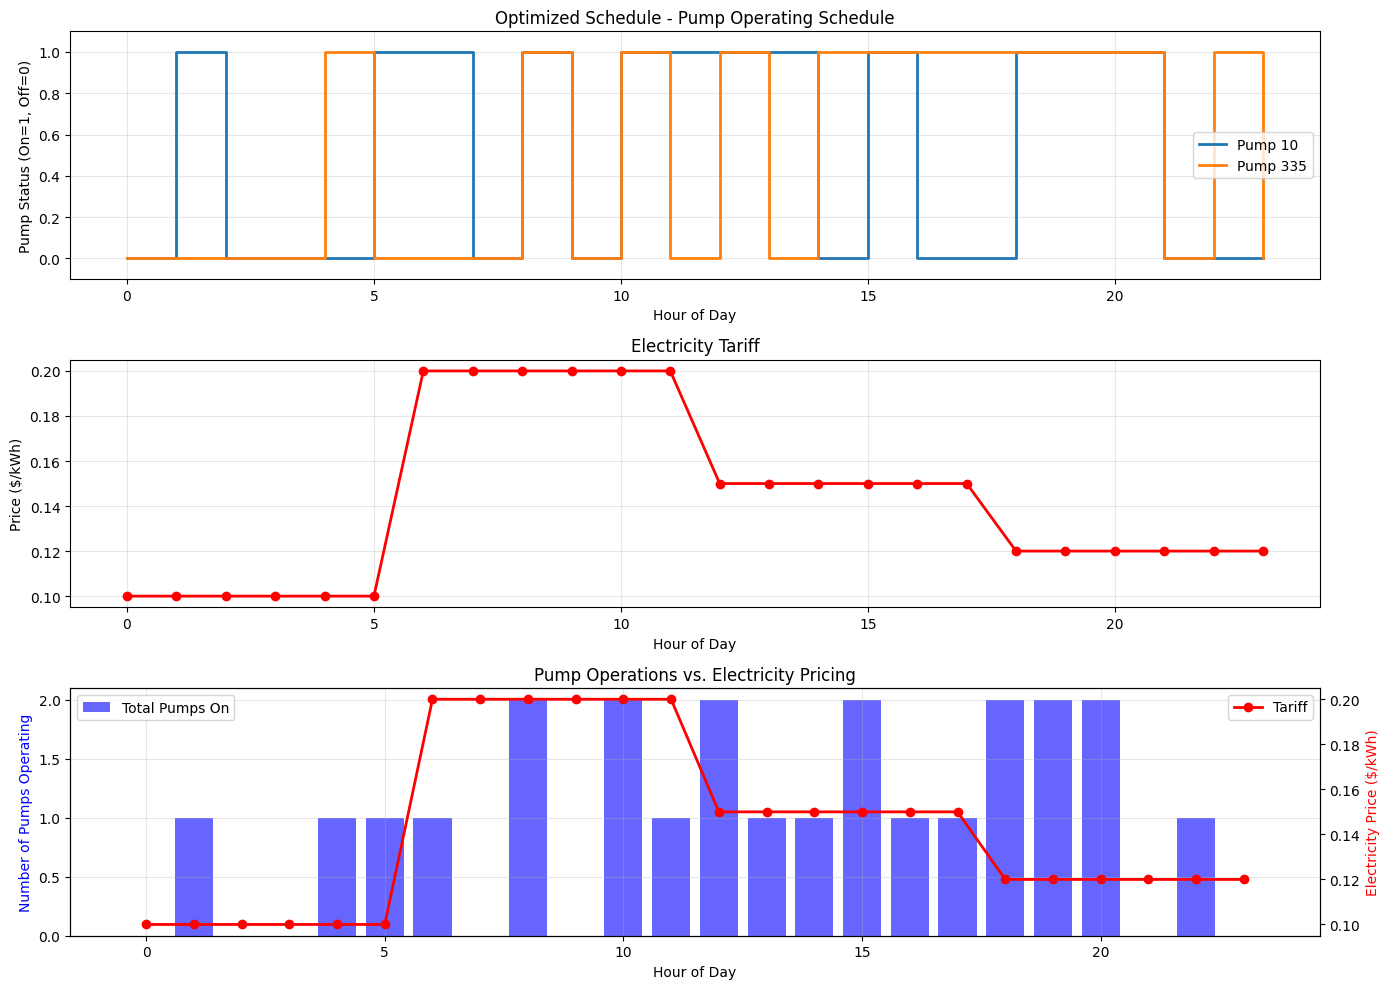

📋 SCHEDULE EFFICIENCY ANALYSIS
Pump 10: 12 hours operated
Pump 335: 12 hours operated

Operations during high-cost hours: 14
Operations during low-cost hours: 10
Low-cost operation ratio: 41.67%

Peak hours operations: 20
Off-peak hours operations: 4


In [81]:
# Visualization and analysis tools
def plot_schedule_and_analysis(schedule, tariff, title="Pump Schedule"):
    """Plot pump schedule with tariff overlay and analysis."""
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Plot 1: Pump schedules
    hours = list(range(24))
    pump_names = list(schedule.keys())
    
    for i, pump_name in enumerate(pump_names):
        axes[0].step(hours, schedule[pump_name], where='post', 
                    label=f'Pump {pump_name}', linewidth=2)
    
    axes[0].set_title(f'{title} - Pump Operating Schedule')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Pump Status (On=1, Off=0)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(-0.1, 1.1)
    
    # Plot 2: Electricity tariff
    axes[1].plot(hours, tariff[:24], 'r-', linewidth=2, marker='o')
    axes[1].set_title('Electricity Tariff')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('Price ($/kWh)')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Combined analysis
    total_pumps = [sum(schedule[pump][h] for pump in pump_names) for h in hours]
    axes[2].bar(hours, total_pumps, alpha=0.6, color='blue', label='Total Pumps On')
    
    # Overlay tariff on secondary y-axis
    ax2 = axes[2].twinx()
    ax2.plot(hours, tariff[:24], 'r-', linewidth=2, marker='o', label='Tariff')
    
    axes[2].set_title('Pump Operations vs. Electricity Pricing')
    axes[2].set_xlabel('Hour of Day')
    axes[2].set_ylabel('Number of Pumps Operating', color='blue')
    ax2.set_ylabel('Electricity Price ($/kWh)', color='red')
    axes[2].legend(loc='upper left')
    ax2.legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_schedule_efficiency(schedule, tariff):
    """Analyze the efficiency of a pump schedule."""
    pump_names = list(schedule.keys())
    
    print("📋 SCHEDULE EFFICIENCY ANALYSIS")
    print("="*50)
    
    # Operating hours per pump
    for pump_name in pump_names:
        total_hours = sum(schedule[pump_name])
        print(f"Pump {pump_name}: {total_hours} hours operated")
    
    # Cost efficiency analysis
    high_cost_hours = [h for h in range(24) if tariff[h] > np.mean(tariff)]
    low_cost_hours = [h for h in range(24) if tariff[h] <= np.mean(tariff)]
    
    total_high_cost_ops = sum(
        sum(schedule[pump][h] for pump in pump_names) 
        for h in high_cost_hours
    )
    total_low_cost_ops = sum(
        sum(schedule[pump][h] for pump in pump_names) 
        for h in low_cost_hours
    )
    
    print(f"\nOperations during high-cost hours: {total_high_cost_ops}")
    print(f"Operations during low-cost hours: {total_low_cost_ops}")
    
    if total_high_cost_ops + total_low_cost_ops > 0:
        efficiency_ratio = total_low_cost_ops / (total_high_cost_ops + total_low_cost_ops)
        print(f"Low-cost operation ratio: {efficiency_ratio:.2%}")
    
    # Peak/off-peak analysis
    peak_hours = list(range(6, 22))  # 6 AM to 10 PM
    off_peak_hours = list(range(0, 6)) + list(range(22, 24))
    
    peak_ops = sum(
        sum(schedule[pump][h] for pump in pump_names) 
        for h in peak_hours
    )
    off_peak_ops = sum(
        sum(schedule[pump][h] for pump in pump_names) 
        for h in off_peak_hours
    )
    
    print(f"\nPeak hours operations: {peak_ops}")
    print(f"Off-peak hours operations: {off_peak_ops}")

# Test visualization with the best schedule found
if 'best_schedule' in locals():
    plot_schedule_and_analysis(best_schedule, tariff, "Optimized Schedule")
    analyze_schedule_efficiency(best_schedule, tariff)
else:
    print("Run the LNS optimization first to generate best_schedule")